In [18]:
# Library
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn import feature_extraction
from bs4 import BeautifulSoup
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_score

In [2]:
# Load the data
data = pd.read_csv('cleaned_data.csv')
data.shape

(174094, 7)

In [3]:
# check for missing values
print(data.isnull().sum())
# Drop missing values
data = data.dropna()
# check for deplicate values
print("Duplicates:", data.duplicated().sum())
# Drop duplicates
data = data.drop_duplicates()
# Verify shape of cleaned data
print("Cleaned data shape:", data.shape)

Title               0
review/score        0
review/text         0
description         3
authors          1022
categories         70
publishedDate       0
dtype: int64
Duplicates: 3603
Cleaned data shape: (169396, 7)


In [4]:
data.head()

,Title,review/score,review/text,description,authors,categories,publishedDate
0,The Church of Christ: A Biblical Ecclesiology ...,5.0,publication everett ferguson book ecclesiology...,church christ biblical ecclesiology today resp...,Everett Ferguson,Religion,1996
1,The Church of Christ: A Biblical Ecclesiology ...,5.0,everett ferguson approaches subject early chri...,church christ biblical ecclesiology today resp...,Everett Ferguson,Religion,1996
2,The Church of Christ: A Biblical Ecclesiology ...,4.0,book continual resource biblical simple dr fer...,church christ biblical ecclesiology today resp...,Everett Ferguson,Religion,1996
3,The Church of Christ: A Biblical Ecclesiology ...,4.0,useful thorough text book would recommend anyo...,church christ biblical ecclesiology today resp...,Everett Ferguson,Religion,1996
4,The Battleship Bismarck,3.0,book history photo album famous german battles...,bismarck perhaps famous notorious warship ever...,Stefan Draminski,History,2018-09-20


In [5]:
# Take some sample of the data. Since data is too large, TF-IDF take too long to calculate
np.random.seed(100)
data = data.sample(10000)

## Text Feature Engineering

In [6]:
# input prepreocess text
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc if not token.is_stop and token.is_alpha)

data["description_preprocessed"] = data["description"].apply(preprocess)

In [7]:
# Create feature vectors for TF_IDF
vectorizer = TfidfVectorizer()
description_matrix = vectorizer.fit_transform(data["description_preprocessed"])

In [8]:
# Recommendation function
def recommend_book(input_text, top_n=1):
    input_text_preprocessed = preprocess(input_text)
    input_vector = vectorizer.transform([input_text_preprocessed])
    
    similarity_scores = cosine_similarity(input_vector, description_matrix)
    best_match_index = np.argmax(similarity_scores)
    
    return data.iloc[best_match_index]

In [9]:
# Test the recommendation system
input_text = "A science mystery novel with prospective."
recommended_book = recommend_book(input_text)
print(recommended_book)

Title                       Bradbury Classic Stories 1: From the Golden Ap...
review/score                                                              5.0
review/text                 anything collection reasserts treasure bradbur...
description                 collection thirty two classic stories fantasy ...
authors                                                          Ray Bradbury
categories                                                            Fiction
publishedDate                                                            1990
description_preprocessed    collection thirty classic story fantasy scienc...
Name: 129033, dtype: object


## Clustering model:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


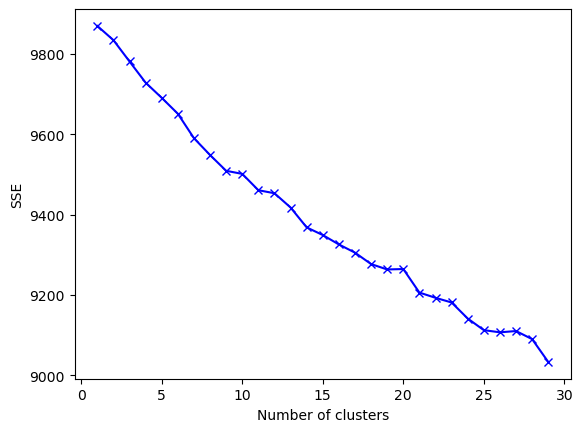

In [10]:
# Apply the K-means clustering algorithm
np.random.seed(100)
SSE = [] 
K = range(1,30)
for k in K: 
    kmeans = KMeans(n_clusters = k, init='k-means++')
    kmeans.fit(description_matrix) 
    SSE.append(kmeans.inertia_)

plt.plot(K, SSE, 'bx-') 
plt.xlabel('Number of clusters') 
plt.ylabel('SSE') 
plt.show() 

In [11]:
# Apply the K-means clustering algorithm
km = KMeans(n_clusters = 21, init = 'k-means++',random_state=100)
km.fit(description_matrix)

# Compute the Silhouette Score
predicted_labels = km.labels_
silhouette = silhouette_score(description_matrix, predicted_labels)
print("Silhouette Score:", silhouette)

# Convert the sparse matrix to a dense array
dense_description_matrix = description_matrix.toarray()

# Compute the Calinski-Harabasz Score
ch_score = calinski_harabasz_score(dense_description_matrix, predicted_labels)
print("Calinski-Harabasz Score:", ch_score)

# Compute the Davies-Bouldin Score
db_score = davies_bouldin_score(dense_description_matrix, predicted_labels)
print("Davies-Bouldin Score:", db_score)

Silhouette Score: 0.04762469742518506
Calinski-Harabasz Score: 36.260453503561045
Davies-Bouldin Score: 4.618974796582636


In [12]:
# create the rank of documents 
ranks = []
for i in range(1, len(data["description_preprocessed"])+1):
    ranks.append(i)
    
#final clusters
clusters = km.labels_.tolist()
cluster_data = { 'rating': ranks, 'description': data["description_preprocessed"], 'cluster': clusters }
frame = pd.DataFrame(cluster_data, index = [clusters] , columns = ['rank', 'cluster'])

#number of docs per cluster
frame['cluster'].value_counts()

20    6676
1      562
5      334
12     327
16     324
7      275
9      233
11     180
3      167
19     161
18      91
17      90
8       80
2       78
14      71
6       70
10      67
0       62
4       62
13      49
15      41
Name: cluster, dtype: int64

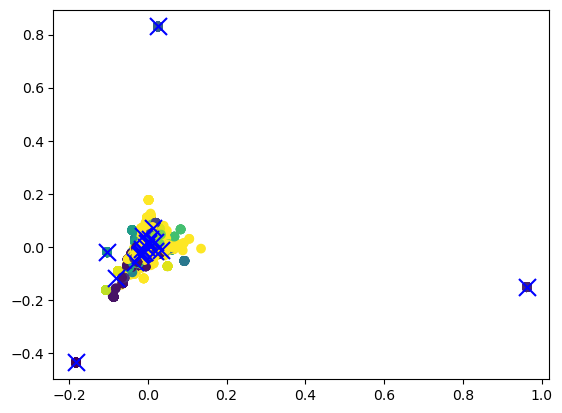

In [13]:
from sklearn.decomposition import PCA
# reduce the features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(description_matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(description_matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

## Visualization

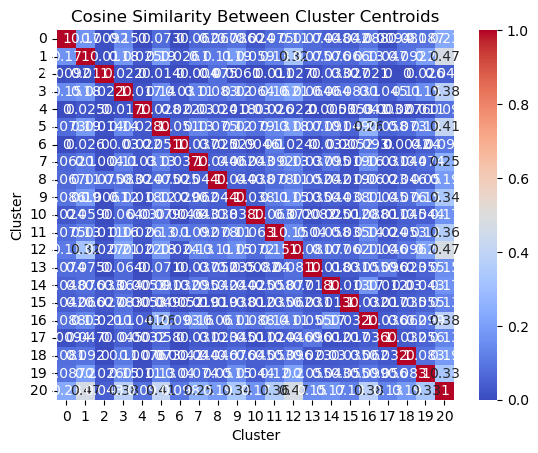

In [ ]:
import seaborn as sns

# Calculate the cosine similarity between cluster centroids
centroids = km.cluster_centers_
similarity_matrix = cosine_similarity(centroids)

# Plot the heatmap
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", figsize=(12, 10))
plt.title("Cosine Similarity Between Cluster Centroids", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Cluster", fontsize=14)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(description_matrix)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=7)
agg.fit(description_matrix)

# Spectral Clustering
spec = SpectralClustering(n_clusters=7)
spec.fit(description_matrix)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply PCA or t-SNE for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(description_matrix)

# Or use t-SNE
# tsne = TSNE(n_components=2, random_state=0)
# reduced_features = tsne.fit_transform(description_matrix)

# Plot the clustering results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=km.labels_, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustering Visualization')
plt.show()


In [14]:
# # BERT feature extraction
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")

# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(axis=1).detach().numpy()

# data["bert_embedding"] = data["description_preprocessed"].apply(get_bert_embedding)

# # Standardize BERT embeddings
# scaler = StandardScaler()
# bert_embeddings = np.vstack(data["bert_embedding"].values)
# scaled_bert_embeddings = scaler.fit_transform(bert_embeddings)

# # Cluster books using K-Means
# n_clusters = 20
# kmeans = KMeans(n_clusters=n_clusters)
# data["cluster"] = kmeans.fit_predict(scaled_bert_embeddings)

# # Recommendation function
# def recommend_book(input_text, top_n=1):
#     input_text_preprocessed = preprocess(input_text)
#     input_bert_embedding = get_bert_embedding(input_text_preprocessed)
#     input_scaled_bert_embedding = scaler.transform(input_bert_embedding)
    
#     input_cluster = kmeans.predict(input_scaled_bert_embedding)
#     filtered_books = data[data["cluster"] == input_cluster[0]]

#     similarity_scores = []
#     for book_embedding in filtered_books["bert_embedding"]:
#         similarity_scores.append(torch.nn.functional.cosine_similarity(
#             torch.tensor(input_bert_embedding), torch.tensor(book_embedding))[0].item())
    
#     best_match_index = np.argmax(similarity_scores)
    
#     return filtered_books.iloc[best_match_index]
# # Test the recommendation system
# input_text = "A thrilling mystery novel with unexpected twists."
# recommended_book = recommend_book(input_text)
# print(recommended_book)

In [15]:
# Flask for clustering file
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/recommend", methods=["POST"])
def recommend():
    data = request.get_json()
    input_text = data.get("input_text")
    if input_text:
        recommended_book = recommend_book(input_text)
        response = {
            "Title": recommended_book["Title"],
            "Rating score": recommended_book["review/score"],
            "Review text": recommended_book["review/text"],
            "Description": recommended_book["description"],
            "Authors": recommended_book["authors"] if not pd.isna(recommended_book["authors"]) else "Unknown",
            "Categories": recommended_book["categories"],
            "Published Date": recommended_book["publishedDate"]
        }
        return jsonify(response)